In [1]:
import geopandas as gpd
import xarray as xr
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Load python library

In [3]:
import geomed3d

# Parameters

In [4]:
# processing resolution, depth, range filter, meter
resolution = 15
DEPTH=1000
SIGMA1=1000
SIGMA2=1150

# use constant value or band name
DEM  = '../data/ref/DSM.15m.32645.nc'
#DEM = 0
AREA = '../data/ref/vein13.32645.geojson'

RASTER = '../data/ref/DSM.15m.32645.nc'
# stop processing if raster is not defined

# postprocessing
q = {
    'density':     [0.5,99.5],
    'halteration': [2,98],
    'valteration': [2,98],
    'hanomaly':    [2,98],
    'vanomaly':    [2,98]
}

## Load work area

POLYGON ((343067.5786291836 6050402.286796309, 343080.6829878398 6046629.210715493, 345009.822386579 6046590.558734349, 345030.41555213 6050360.606018774, 343067.5786291836 6050402.286796309))


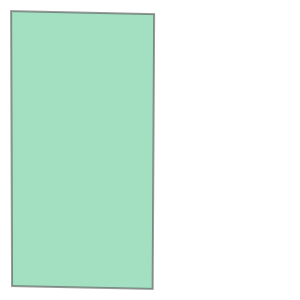

In [5]:
area = gpd.read_file(AREA)
print(area.geometry[0])
area.geometry[0]

## Load raster

In [6]:
raster0 = xr.open_dataarray(RASTER)

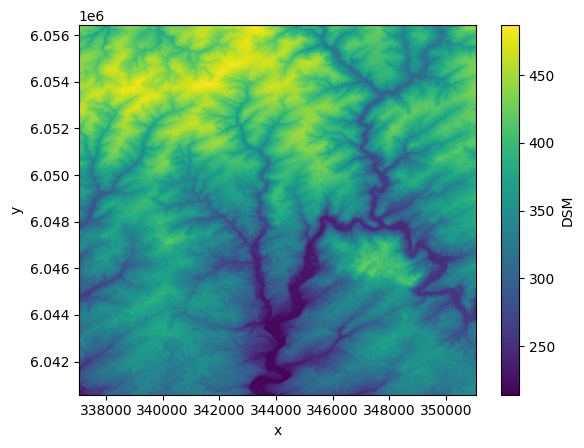

In [7]:
raster0.plot()

## Load DEM if defined

In [8]:
if isinstance(DEM,str):
    dem = xr.open_dataarray(RASTER)
elif DEM is None or isinstance(DEM,int) or isinstance(DEM,float):
    dem = DEM if DEM is not None else 0
dem

<xarray.DataArray 'DSM' (y: 1057, x: 933)>
[986181 values with dtype=int16]
Coordinates:
  * y        (y) float64 6.056e+06 6.056e+06 6.056e+06 ... 6.041e+06 6.041e+06
  * x        (x) float64 3.371e+05 3.371e+05 3.371e+05 ... 3.51e+05 3.51e+05
Attributes:
    transform:               [ 1.50000e+01  0.00000e+00  3.37050e+05  0.00000...
    crs:                     +init=epsg:32645
    res:                     [15. 15.]
    is_tiled:                1
    nodatavals:              -32768.0
    scales:                  1.0
    offsets:                 0.0
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

# Pre-processing

In [9]:
raster = geomed3d.geomed3d.gaussian_range(raster0, SIGMA1/resolution, SIGMA2/resolution)

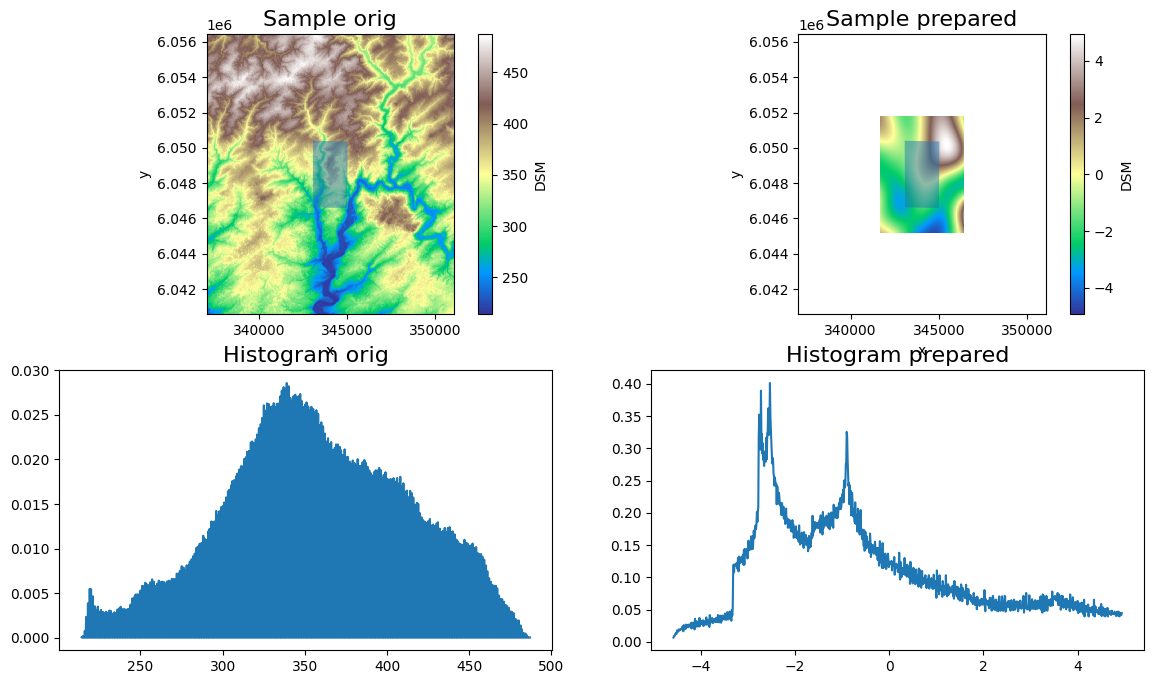

In [10]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(14, 8))

raster0.plot(ax=ax1, cmap='terrain')
area.plot(ax=ax1, alpha=0.5)
ax1.set_title('Sample orig',fontsize=16)

raster.plot(ax=ax2, cmap='terrain')
area.plot(ax=ax2, alpha=0.5)
#area.buffer(1000).plot(ax=ax2, alpha=0.5)

ax2.set_title('Sample prepared',fontsize=16)

hist, bin_edges = np.histogram(raster0, bins=1000, density=True)
ax3.plot(bin_edges[1:],hist)
ax3.set_title('Histogram orig',fontsize=16)

hist, bin_edges = np.histogram(raster, bins=1000, density=True,
                              range=(np.nanmin(raster.values),np.nanmax(raster.values)))
ax4.plot(bin_edges[1:],hist)
ax4.set_title('Histogram prepared',fontsize=16)

fig.subplots_adjust(hspace=0.2)
plt.show()

### Make grid from loaded area

In [11]:
(minx, miny, maxx, maxy) = area.geometry[0].bounds
(minx, miny, maxx, maxy)

(343067.5786291836, 6046590.558734349, 345030.41555213, 6050402.286796309)

In [12]:
if isinstance(DEM,str):
    grid = dem.sel(x=slice(minx,maxx),y=slice(maxy,miny))
    df_grid = grid.sel(x=slice(minx,maxx),y=slice(maxy,miny)).to_dataframe('z').reset_index()
elif DEM is None or isinstance(DEM,int) or isinstance(DEM,float):
    grid = raster0.sel(x=slice(minx,maxx),y=slice(maxy,miny))
    df_grid = grid.sel(x=slice(minx,maxx),y=slice(maxy,miny)).to_dataframe('z').reset_index()
    df_grid['z'] = dem
df_grid

,y,x,z
0,6050392.5,343072.5,399
1,6050392.5,343087.5,400
2,6050392.5,343102.5,401
3,6050392.5,343117.5,402
4,6050392.5,343132.5,401
...,...,...,...
33269,6046597.5,344962.5,273
33270,6046597.5,344977.5,268
33271,6046597.5,344992.5,262
33272,6046597.5,345007.5,258


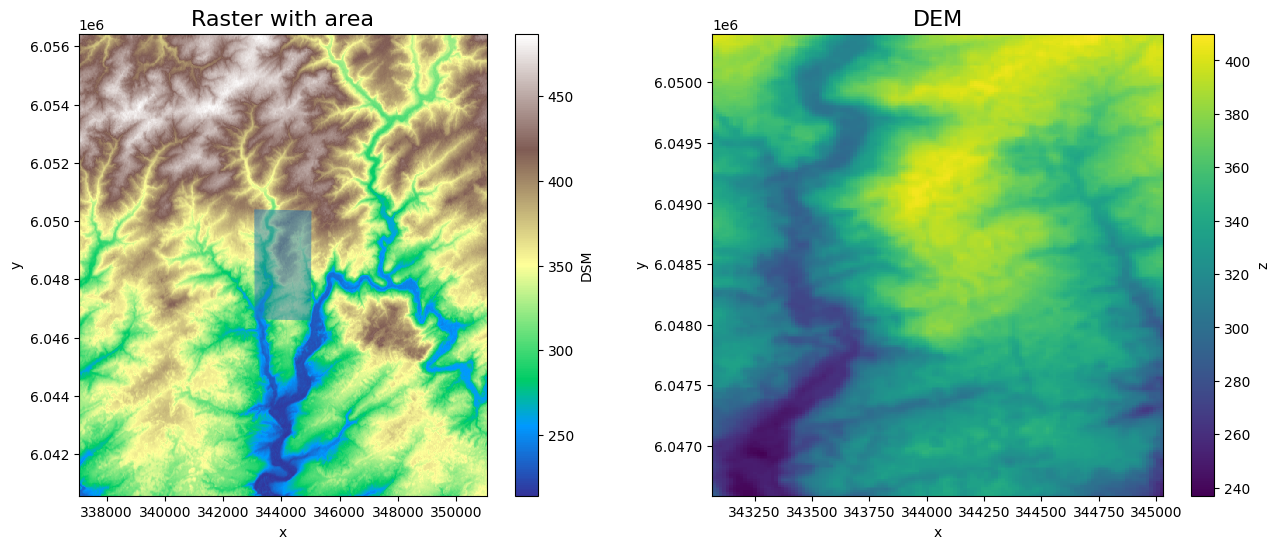

In [13]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))

raster0.plot(cmap='terrain', ax=ax1)
#ax1.scatter(df_grid.x,df_grid.y, s=0.0005, c='red')
area.plot(ax=ax1, alpha=0.5)
ax1.set_title('Raster with area',fontsize=16)

xr.Dataset.from_dataframe(df_grid.set_index(['y','x'])[['z']]).z.plot(ax=ax2)
ax2.set_title('DEM',fontsize=16)

fig.subplots_adjust(hspace=0.15)
plt.show()

# 3D volume

In [14]:
%%time

radius = int(round(DEPTH/(resolution*0.707),0))
print ('radius', radius)
ds3d = geomed3d.geomed3d.compute(raster, df_grid, radius)
ds3d

radius 94
CPU times: user 6.21 s, sys: 210 ms, total: 6.42 s
Wall time: 6.38 s


<xarray.Dataset>
Dimensions:      (y: 254, x: 131, z: 94)
Coordinates:
  * y            (y) float64 6.047e+06 6.047e+06 6.047e+06 ... 6.05e+06 6.05e+06
  * x            (x) float64 3.431e+05 3.431e+05 3.431e+05 ... 3.45e+05 3.45e+05
  * z            (z) float64 403.1 392.4 381.8 371.2 ... -562.1 -572.8 -583.4
Data variables:
    density      (z, y, x) float32 nan nan nan nan nan ... 1.619 1.613 1.607 1.6
    halteration  (z, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    valteration  (z, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    hanomaly     (z, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    vanomaly     (z, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0

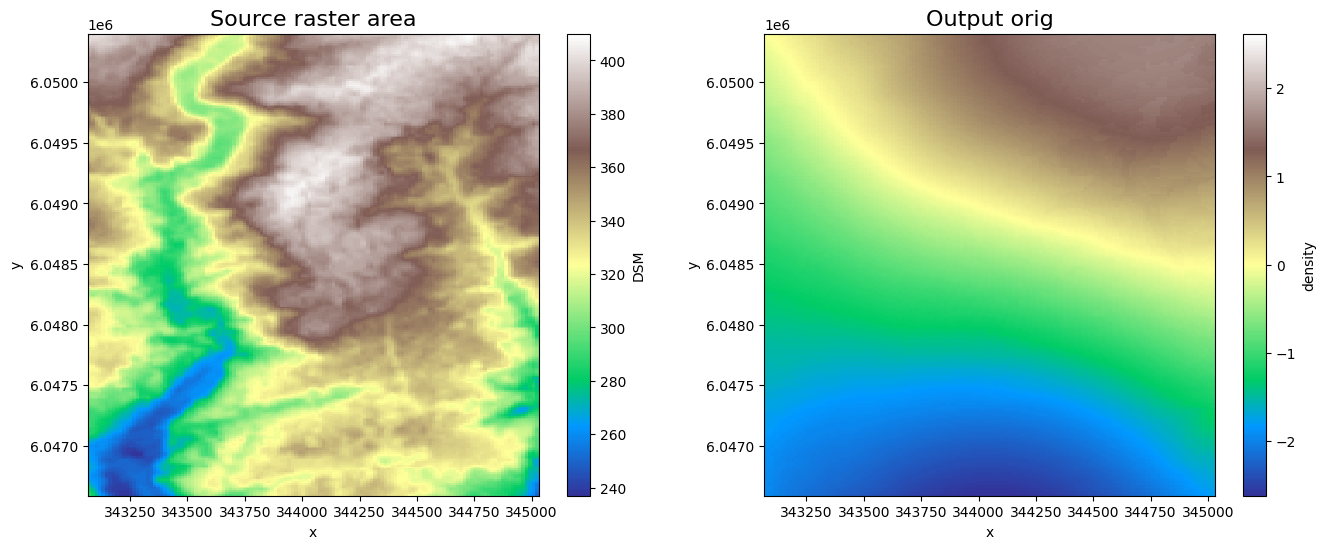

In [15]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))

grid.plot(cmap='terrain', ax=ax1)
ax1.set_title('Source raster area',fontsize=16)

ds3d.density.isel(z=-1).plot(cmap='terrain', ax=ax2)
ax2.set_title('Output orig',fontsize=16)

fig.subplots_adjust(hspace=0.15)
plt.show()

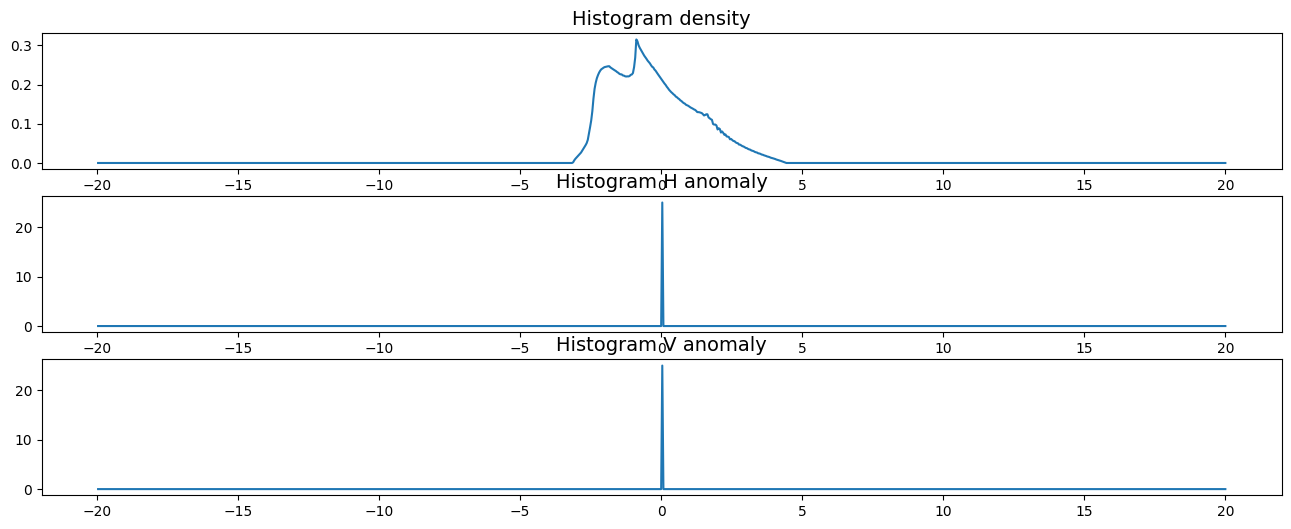

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(16, 6))

hist, bin_edges = np.histogram(ds3d.density, bins=1000, density=True,
                              range=(-20,20))
ax1.plot(bin_edges[1:],hist)
ax1.set_title('Histogram density', fontsize=14)

hist, bin_edges = np.histogram(ds3d.hanomaly, bins=1000, density=True,
                              range=(-20,20))
ax2.plot(bin_edges[1:],hist)
ax2.set_title('Histogram H anomaly', fontsize=14)

hist, bin_edges = np.histogram(ds3d.vanomaly, bins=1000, density=True,
                              range=(-20,20))
ax3.plot(bin_edges[1:],hist)
ax3.set_title('Histogram V anomaly', fontsize=14)

plt.show()

## Analyze and output the data

crop hist density -2.8338288486003878 3.7903850972652435
crop hist halteration 0.0 0.0
crop hist valteration 0.0 0.0
crop hist hanomaly 0.0 0.0
crop hist vanomaly 0.0 0.0


/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: invalid value encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))
/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: invalid value encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))
/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: invalid value encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))
/Users/mbg/Documents/github-public/geomed3d/geomed3d/vtk.py:55: RuntimeWarning: invalid value encountered in divide
  vals = 100.*(da.values - np.nanmin(da.values))/(np.nanmax(da.values)-np.nanmin(da.values))


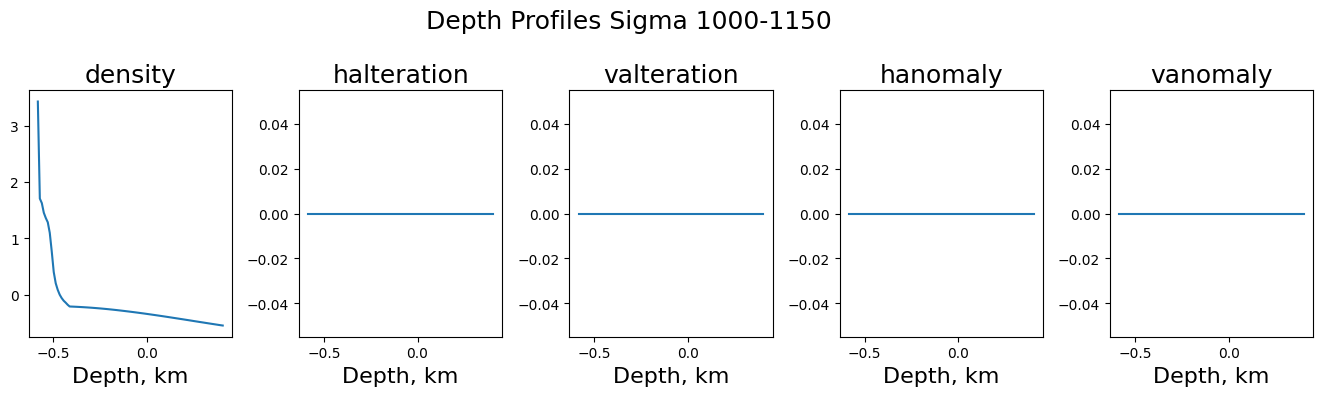

In [17]:
fig = plt.figure(figsize=(14,4))
for idx,stat in enumerate(ds3d.data_vars):
    #print (idx,stat)
    da = ds3d[stat].copy()
    # reverse z axis
    da = da.reindex(z=da.z[::-1])
    # crop histogramm
    pcnt = np.nanpercentile(da.values.reshape(-1),q[stat])
    da.values = np.clip(da.values,pcnt[0],pcnt[1])
    print ('crop hist', stat, pcnt[0], pcnt[1])
    # plot
    ax = fig.add_subplot(1, len(ds3d.data_vars), idx+1)
    ax.plot(ds3d.density.z/1000, da.mean(['y','x']))
    ax.set_title(stat, fontsize=18)
    ax.set_xlabel('Depth, km', fontsize=16)
    # save 3D data to VTK (version 1) files
    fname = f'../data/interim/{stat}.v5.vtk'
    geomed3d.vtk.da2vtk_scalar(da, fname)

plt.suptitle(f'Depth Profiles Sigma {SIGMA1}-{SIGMA2}', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.98])
plt.show()